# fMRI INR

## Dependencies

In [40]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
from einops import rearrange, repeat
import einops
from glob import glob
from math import log
import math
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
from nilearn.image import index_img
from torch.utils.data import DataLoader, Subset

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

In [42]:
###- DS LOCATION CONFIRMATION -###

file_path = "/home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii"

# verify the file exists
if os.path.exists(file_path):
    print(f"YES! File found at: {file_path}")
else:
    print(f"Error: File not found at: {file_path}")
    
# loads ds
fmri = nib.load(file_path)

YES! File found at: /home/idies/workspace/Temporary/ecardillo/scratch/fmri/jubin-ds.nii


## Volume and Slice Selection

(91, 109, 91, 1200)


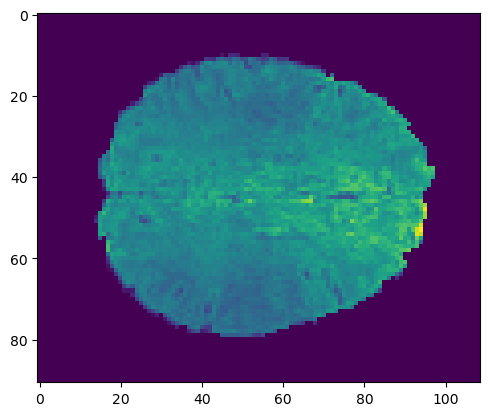

In [61]:
###- GET VOLUME AT TIMEPOINT, GET SLICE FROM VOLUME -###

print(fmri.shape)

# sets timepoint (out of 1200)
timepoint = 50 

# gets volume (instantiates 3D brain at timepoint)
single_volume = index_img(fmri, timepoint)
arr = single_volume.get_fdata()

# takes zth slice of volume (slice/image depth)
z_idx = [30,40,50,60,70]
slice = arr[:,:, z_idx[2]]

plt.imshow(slice)

## Normalization

-4.463201462811106 5.730761050590585e-17 5.128954352209998 (91, 109)
0 255 (91, 109)
The image resolution is: 109x91


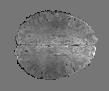

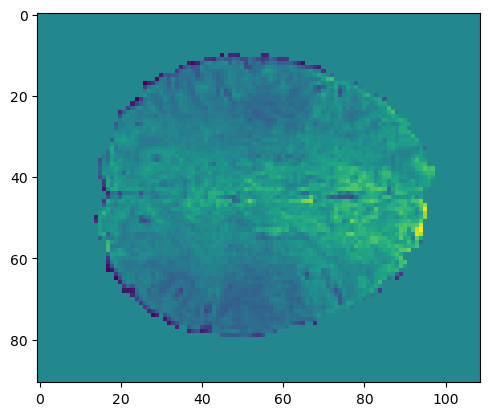

In [69]:
###- NORMALIZE SLICES -###

# only takes slices with intensity (everything but bg)
nonzero = slice[slice > 0]

# takes only black spaces (all bg)
back = slice == 0

# takes the mean and standard deviation of the brain component
m_, std_ = nonzero.mean(), nonzero.std()

# normalize 
norm_slice = (slice - m_) / std_
norm_slice[back] = 0
print(norm_slice.min(), norm_slice.mean(), norm_slice.max(), norm_slice.shape)
np.save('ground_truth.npy', norm_slice)
min_val = norm_slice.min()
max_val = norm_slice.max()

# stretch the values to fill the 0-255 range for the image
scaled_slice = 255 * (norm_slice - min_val) / (max_val - min_val)

# convert the scaled data to unsigned 8-bit integers 
image_array = scaled_slice.astype(np.uint8)
print(image_array.min(), image_array.max(), image_array.shape)

# create an image from the array and save it
img = Image.fromarray(image_array)
img.save('ground_truth.jpg')

# preview image
print(f"The image resolution is: {W}x{H}")
img.show()

# display normalized slice
plt.imshow(norm_slice)

## Dataframe

In [150]:
###- BUILD DATAFRAME -###

bw_array = norm_slice.T  # transpose to (height, width)

height, width = bw_array.shape
print(f"Shape of transposed slice: {bw_array.shape}")

# Create coordinate grids
x_coords, y_coords = np.meshgrid(np.arange(height), np.arange(width))

# Flatten everything and create df
x_flat = x_coords.ravel()
y_flat = y_coords.ravel()
intensity_flat = bw_array.ravel()


min_int = np.min(intensity_flat)
max_int = np.max(intensity_flat)
print(max_int)
print(min_int)
df = pd.DataFrame({
    "x_pos": x_flat/(height-1),
    "y_pos": y_flat/(width-1),
    # [0 to 1] standardization    
    "intensity": intensity_flat
})

df.head()


Shape of transposed slice: (109, 91)
5.128954352209998
-4.463201462811106


,x_pos,y_pos,intensity
0,0.000000,0.0,0.0
1,0.009259,0.0,0.0
2,0.018519,0.0,0.0
3,0.027778,0.0,0.0
4,0.037037,0.0,0.0


## Model Definition

In [151]:
###- INR IMAGE ARCHITECTURE -###

class fMRI_INRModel(torch.nn.Module):
    # nn constructor
    def __init__(self, input_size, hidden_size = 256, output_size = 1, num_hidden = 4):
        super(fMRI_INRModel, self).__init__()
        # input - 2 - x,y
        # hidden_size - 256 - num of hidden neurons
        # output - 1 - intensity
        # num_hidden - 4 - num of hidden layers

        # creates first fully-connected layer
        self.input = torch.nn.Linear(input_size, hidden_size)

        # builds hidden network layers
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        self.hidden = nn.Sequential(*layers)
        self.output = torch.nn.Linear(hidden_size, output_size)   

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)

        return x

## Dataset Definition

In [152]:
# dataset to customize type of positional encoding of input
class ImageINRDatasetFourier(Dataset):
    def __init__(self, dataframe, fourier = False, gaussian = False, num_freq = 1, freq_param = None, freq_file = 'freq.pkl', gauss_scale = 1):
        self.dataframe = dataframe

        freq = np.random.normal(0, 1, size = num_freq*2)*gauss_scale
        pickle.dump(freq, open(freq_file, "wb"))
        x = dataframe['x_pos']
        y = dataframe['y_pos']
        xy = torch.tensor(np.stack([x, y], axis=-1), dtype = torch.float32)
        self.x = fourier_encode(xy, freq)

        self.y = torch.tensor(dataframe[['intensity']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [153]:
# pass in a frequency array and and xy grid, return cos/sin of 2x/f and 2y/f for f in freq
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:
    xy = xy.unsqueeze(1)
    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]
    
    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    scaled1 = 2 * torch.pi * (1/freq1) * xy  
    scaled2 = 2 * torch.pi * (1/freq2) * xy  

    sin_feat = torch.sin(scaled1)  
    cos_feat = torch.cos(scaled2)  


    features = torch.cat([sin_feat, cos_feat], dim=-1)  
    return features.view(xy.shape[0], -1)  

## Training

In [154]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    
    # if you are using multi-GPU, these lines ensure deterministic results
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Random seeds set to {seed}")

In [155]:
###- MAIN TRAINING LOOP -###

def train(num_freq, model_type, model_file='checkpoint.pth', loss_file='losses', freq_file='freq.pkl', gauss_scale=1):
    
    seed_everything(42)

    if model_type == 'gaussian':
        # init full dataset using Fourier features
        data = ImageINRDatasetFourier(df, gaussian=True, num_freq=num_freq, freq_file=freq_file, gauss_scale=gauss_scale)
        # init model
        model = fMRI_INRModel(input_size=4 * num_freq).to(device)
    else:
        print('Invalid model_type specified.')
        return
        

    #--- DEV SET SPLIT ---#

    # gets ds size (expected 9919)
    ds_size = len(data)
    # indexes length of ds
    indices = list(range(ds_size))

    # randomizes indices (keep seed for reproducibility)
    np.random.shuffle(indices)
    
    # calculates size of training set (80% of full set)
    train_split = int(np.floor(0.8 * ds_size))
    
    # calculates size of validation set (10% of full set)
    val_split = int(np.floor(0.9 * ds_size))

    # 0 - train_split .. (80%)
    train_indices = indices[:train_split]
    # train_split - val_split .. (10%)
    val_indices = indices[train_split:val_split]
    # val_split - END .. (10%)
    test_indices = indices[val_split:]

    # create subsets
    train_dataset = Subset(data, train_indices)
    val_dataset = Subset(data, val_indices)
    test_dataset = Subset(data, test_indices) # TEST - *not used in training

    print(f"DS SPLIT: {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} testing.")

    train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True,)
    valid_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=False,)

    
    #--- TRAINING ---#
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    patience = 20  
    epochs_no_improve = 0
    best_val_loss = float('inf')
    
    train_losses = []
    valid_losses = []

    num_epochs = 200

    for epoch in tqdm(range(num_epochs)):
        model.train()  
        
        running_train_loss = 0.0
        
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_train_loss)

                 
        #--- VALIDATION ---#
        
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(valid_dataloader.dataset)
        valid_losses.append(epoch_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }

        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            print(f"Best validation loss: {best_val_loss:.6f}")
            break

        torch.save(checkpoint, model_file)


In [156]:
train(
    num_freq=256,
    model_type='gaussian', 
    model_file='early_gaussian_run.pth', 
    loss_file='early_gaussian_loss', 
    freq_file='early_gau.pkl', 
    gauss_scale=10
)

Random seeds set to 42
DS SPLIT: 7935 training, 992 validation, 992 testing.


  5%|▌         | 10/200 [00:02<00:42,  4.45it/s]

Epoch 10/200, Train Loss: 0.419472, Val Loss: 0.373550


 10%|█         | 20/200 [00:04<00:39,  4.50it/s]

Epoch 20/200, Train Loss: 0.401643, Val Loss: 0.353292


 15%|█▌        | 30/200 [00:07<00:38,  4.40it/s]

Epoch 30/200, Train Loss: 0.396276, Val Loss: 0.351989


 20%|██        | 40/200 [00:09<00:38,  4.16it/s]

Epoch 40/200, Train Loss: 0.392742, Val Loss: 0.346993


 25%|██▌       | 50/200 [00:12<00:33,  4.42it/s]

Epoch 50/200, Train Loss: 0.388416, Val Loss: 0.343042


 30%|███       | 60/200 [00:14<00:32,  4.33it/s]

Epoch 60/200, Train Loss: 0.393402, Val Loss: 0.351483


 35%|███▌      | 70/200 [00:16<00:30,  4.20it/s]

Epoch 70/200, Train Loss: 0.385716, Val Loss: 0.343046


 40%|████      | 80/200 [00:19<00:32,  3.64it/s]

Epoch 80/200, Train Loss: 0.378468, Val Loss: 0.365819


 45%|████▌     | 90/200 [00:21<00:32,  3.40it/s]

Epoch 90/200, Train Loss: 0.365574, Val Loss: 0.325689


 50%|█████     | 100/200 [00:24<00:21,  4.57it/s]

Epoch 100/200, Train Loss: 0.348537, Val Loss: 0.325929


 55%|█████▌    | 110/200 [00:26<00:19,  4.67it/s]

Epoch 110/200, Train Loss: 0.359933, Val Loss: 0.326341


 60%|██████    | 120/200 [00:29<00:18,  4.36it/s]

Epoch 120/200, Train Loss: 0.330478, Val Loss: 0.312227


 65%|██████▌   | 130/200 [00:31<00:15,  4.43it/s]

Epoch 130/200, Train Loss: 0.331001, Val Loss: 0.323108


 70%|███████   | 140/200 [00:33<00:13,  4.61it/s]

Epoch 140/200, Train Loss: 0.289183, Val Loss: 0.295274


 75%|███████▌  | 150/200 [00:36<00:11,  4.52it/s]

Epoch 150/200, Train Loss: 0.282931, Val Loss: 0.335229


 80%|███████▉  | 159/200 [00:38<00:09,  4.21it/s]

Epoch 160/200, Train Loss: 0.258921, Val Loss: 0.270527


 85%|████████▌ | 170/200 [00:41<00:07,  4.21it/s]

Epoch 170/200, Train Loss: 0.269330, Val Loss: 0.304068


 90%|█████████ | 180/200 [00:43<00:04,  4.01it/s]

Epoch 180/200, Train Loss: 0.232984, Val Loss: 0.263147


 95%|█████████▌| 190/200 [00:45<00:02,  3.74it/s]

Epoch 190/200, Train Loss: 0.201397, Val Loss: 0.234019


100%|██████████| 200/200 [00:48<00:00,  4.13it/s]

Epoch 200/200, Train Loss: 0.252080, Val Loss: 0.276001


## Visualization

109 91
torch.Size([9919, 1024])
torch.Size([9919, 1]) 109 91
min max of image tensor(0.0833) tensor(0.1038) <class 'torch.Tensor'>
real diff from df tensor(0.0077)
The image resolution is: 109x91
reconstructed


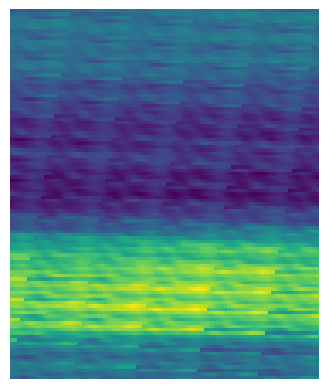

gt


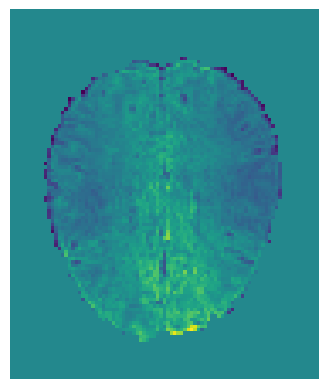

dif


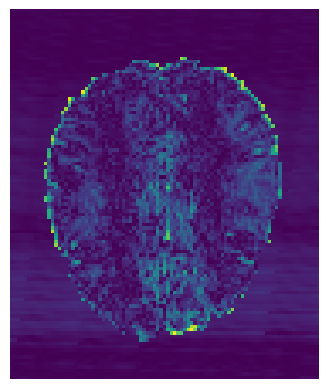

In [149]:
num_freq = 256
model = fMRI_INRModel(input_size = 4*num_freq) 


# define path to model checkpoint 
path = './early_gaussian_run.pth' 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
print(W,H)
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)  # shape: (H, W)

X = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)

# Use this for gaussian to load corresponding frequencies, otherwise comment out
with open('./early_gau.pkl', 'rb') as file:
    freq = pickle.load(file)

X = fourier_encode(X, freq = freq) # comment this line out if using standard or STAF, use freq = [1, 1] for fourier or freq = freq for gaussian
print(X.shape)
with torch.no_grad():
    Y = model(X) 

image = Y.reshape(W, H, 1) # [9019, 1] -> [91, 109, 1]
print(Y.shape, W, H)
print('min max of image',image.min(), image.max(), type(image))

gt_df = torch.Tensor(df.intensity).reshape(W,H,1)
gt_df_diff = torch.sum(torch.abs(gt_df - image), axis=2)
print('real diff from df', gt_df_diff.mean())

print(f"The image resolution is: {W}x{H}")

print('reconstructed')
plt.imshow(image)
plt.axis('off')
plt.show()

print('gt')
plt.imshow(gt_df)
plt.axis('off')
plt.show()

print('dif')
plt.imshow(gt_df_diff)
plt.axis('off')
plt.show()